In [1]:
library(ggplot2)
library(dplyr)
library(plot3D)
library(pracma)
library(latex2exp)
library(emojifont)

Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.2.3"
Warning message:
"pakiet 'dplyr' został zbudowany w wersji R 4.2.3"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"pakiet 'plot3D' został zbudowany w wersji R 4.2.2"
Warning message:
"pakiet 'latex2exp' został zbudowany w wersji R 4.2.2"
Warning message:
"pakiet 'emojifont' został zbudowany w wersji R 4.2.2"


# Zmiany w czasie w modelu 2D z uwzględnieniem kierunku wiatru

źródła:
1. https://en.wikipedia.org/wiki/Rotation_of_axes

In [2]:
data_wind <- read.csv('wind_clouds.csv')
colnames(data_wind) <- c('time','clouds','sun', 'speed', 'direction')

## Funkcje generujące koncentrację zanieczyszczeń

In [3]:
find_category <- function(speed, sun, clouds){
    if(speed<2){
        if(sun>=280) p<-'A'
        else if(sun>=120) p<-'B'
        else if(clouds>=50) p<-'E'
        else p<-'F'
    }
    else if(speed<3){
        if(sun>=479) p<-'A'
        else if(sun>=280) p<-'B'
        else if(sun>=120) p<-'C'
        else if(clouds>=50) p<-'E'
        else p<-'F'
    }
    else if(speed<5){
        if(sun>=280) p<-'B'
        else if(sun>=120) p<-'C'
        else if(clouds>=50) p<-'D'
        else p<-'E'
    }
    else if(speed<6){
        if(sun>=280) p<-'C'
        else p<-'D'
    }
    else{
        if(sun>=479) p<-'C'
        else p<-'D'
    }
    return(p)
}

In [4]:
find_p <- function(category){
    if(category=='A'|category=='B') p <- .15
    else if(category=='C') p <- .2
    else if(category=='D') p <- .25
    else p <- .3
    return(p)
}

In [5]:
find_a_b <- function(x,category){
    if(category=='A'){
        if(x<.1) pars <- c(122.800,0.94470)
        else if(x<.15) pars <- c(158.080,1.05420)
        else if(x<.2) pars <- c(170.220,1.09320)
        else if(x<.25) pars <- c(179.520,1.12620)
        else if(x<.3) pars <- c(217.410,1.26440)
        else if(x<.4) pars <- c(258.890,1.40940)
        else if(x<.5) pars <- c(346.750,1.72830)
        else if(x<=3.11) pars <- c(453.850,2.11660)
        else pars <- c(5000,1)
    }
    else if(category=='B'){
        if(x<.2) pars <- c(90.673,0.93198)
        else if(x<.4) pars <- c(98.483,0.98332)
        else pars <- c(109.300,1.09710)
    }
    else if(category=='C') pars <- c(61.141,0.91465)
    else if(category=='D'){
        if(x<.3) pars <- c(34.459,0.86974)
        else if(x<1) pars <- c(32.093,0.81066)
        else if(x<3) pars <- c(32.093,0.64403)
        else if(x<10) pars <- c(33.504,0.60486)
        else if(x<30) pars <- c(36.650,0.56589)
        else pars <- c(44.053,0.51179)
    }
    else if(category=='E'){
        if(x<.1) pars <- c(24.260,0.83660)
        else if(x<.3) pars <- c(23.331,0.81956)
        else if(x<1) pars <- c(21.628,0.75660)
        else if(x<2) pars <- c(21.628,0.63077)
        else if(x<4) pars <- c(22.534,0.57154)
        else if(x<10) pars <- c(24.703,0.50527)
        else if(x<20) pars <- c(26.970,0.46713)
        else if(x<40) pars <- c(35.420,0.37615)
        else pars <- c(47.618,0.29592)
    }
    else{
        if(x<.2) pars <- c(15.209,0.81558)
        else if(x<.7) pars <- c(14.457,0.78407)
        else if(x<1) pars <- c(13.953,0.68465)
        else if(x<2) pars <- c(13.953,0.63227)
        else if(x<3) pars <- c(14.823,0.54503)
        else if(x<7) pars <- c(16.187,0.46490)
        else if(x<15) pars <- c(17.836,0.41507)
        else if(x<30) pars <- c(22.651,0.32681)
        else if(x<60) pars <- c(27.074,0.27436)
        else pars <- c(34.219,0.21716)
    }
    return(pars)
}

In [6]:
find_theta <- function(x,category){
    if(category=='A') pars <- c(24.1670,2.5334)
    else if(category=='B') pars <- c(18.3330,1.8096)
    else if(category=='C') pars <- c(12.5000,1.0857)
    else if(category=='D') pars <- c(8.3330,0.72382)
    else if(category=='E') pars <- c(6.2500,0.54287)
    else pars <- c(4.1667,0.36191)
    theta <- .017453293*(pars[1]-pars[2]*log(x))
    return(theta)
}

In [7]:
get_concentration <- function(Q,u,h,dy,dz,y,z){
    result = Q/(2*pi*u*dy*dz)*(exp(-(z-h)^2/(2*dz^2))+exp(-(z-h)^2/(2*dz^2)))*exp(-y^2/(2*dy^2))
    return(result)
}

In [8]:
gaussian_plume_xyh <- function(row,y,z, h=10, x_vec=seq(.1,10,.01), Q=0.01){
    category <- find_category(row$speed,row$sun,row$clouds)
    p <- find_p(category)
    cs <- c()
    for(x in x_vec){
        if(x<=0){
            cs <- c(cs,0)
            next
        }
        a_b <- find_a_b(x,category)
        theta <- find_theta(x,category)
        u <- row$speed*(h/10)^p
        a <- a_b[1]
        b <- a_b[2]
        dz <- a*x**b
        if(dz>5000) dz<-5000
        dy <- 465.11628*x*tan(theta)
        c1 <- get_concentration(Q,u,h,dy,dz,y,z)
        cs <- c(cs,c1)
    }
    return(cs)
}

## Funkcja uśredniajaca macierz

In [9]:
pollution_average2 <- function(en,r,c){
    new_matrix <- matrix(data=0, nrow=r, ncol=c)
    new_matrix[1,1] = mean(c(en[1,1],en[2,1],en[1,2],0,0))
    new_matrix[1,c] = mean(c(en[1,c],en[2,c],en[1,(c-1)],0,0))
    new_matrix[r,1] = mean(c(en[r,1],en[(r-1),1],en[r,2],0,0))
    new_matrix[r,c] = mean(c(en[r,c],en[(r-1),c],en[r,(c-1)],0,0))
    for(i in 2:(r-1)) new_matrix[i,1] = mean(c(en[i,1],en[i-1,1],en[i+1,1],en[i,2],0))
    for(i in 2:(r-1)) new_matrix[i,c] = mean(c(en[i,c],en[i-1,c],en[i+1,c],en[i,(c-1)],0))
    for(j in 2:(c-1)) new_matrix[1,j] = mean(c(en[1,j-1],en[1,j],en[1,j+1],en[2,c],0))
    for(j in 2:(c-1)) new_matrix[r,j] = mean(c(en[r,j-1],en[r,j],en[r,j+1],en[(r-1),j],0))
    for(i in 2:(r-1)){
        for(j in 2:(c-1)) new_matrix[i,j] = mean(c(en[i,j],en[i-1,j],en[i+1,j],en[i,j-1],en[i,j+1]))
    }
    return(new_matrix)
}

## Funkcja generująca koncentracje wielu zestawów danych rzeczywistych

In [10]:
gen_in_time <- function(t, sx=seq(0.01,1,0.01), sy=seq(-10,10,.01), z=2){
    for(i in t){
        y <- c()
        cond <- c()
        nx <- length(sx)
        ny <- length(sy)
        nt <- nx*ny
        base <- data_wind[i,]
        for(j in sy){
            y <- c(y,rep(j,nx))
            cond <- c(cond,gaussian_plume_xyh(base,j,z,h=10,x_vec=sx))
        }
        df <- data.frame(y,rep(sx,ny),cond)
        colnames(df) <- c('y','x','cs')
        write.csv(df,paste('./2D/surface',i, '.csv'))
    }
    return(NULL)
}

## Funkcja "obracająca" zbiór punktów zgodnie z kierunkiem wiatru

In [11]:
transform_angle <- function(df,angle){
    x1 <- round(df$x*cos(angle*2*pi/360)-df$y*sin(angle*2*pi/360),2)
    y1 <- round(df$y*cos(angle*2*pi/360)+df$x*sin(angle*2*pi/360),2)
    result <- data.frame(x=x1,y=y1,cs=df$cs)
    result <- result %>% group_by(x,y) %>% summarize(cs=mean(cs))
    final <- df[,c('y','x')] %>% left_join(result, by=c('y','x'))
    final[is.na(final$cs),'cs']=0
    return(final)
}

# Generowanie koncentracji dla przykładowych danych

In [31]:
head(data_wind)

,time,clouds,sun,speed,direction
,<chr>,<int>,<dbl>,<dbl>,<int>
1,2021-01-01T00:00,100,0,0.72,56
2,2021-01-01T01:00,100,0,0.85,69
3,2021-01-01T02:00,100,0,0.10,360
4,2021-01-01T03:00,96,0,0.78,230
5,2021-01-01T04:00,93,0,0.76,203
6,2021-01-01T05:00,99,0,0.85,159


In [13]:
gen_in_time(1:5, sx=seq(0.01,2.01,0.01))

NULL

In [4]:
surface1 <- read.csv('./2D/surface 1 .csv')[,2:4]
surface2 <- read.csv('./2D/surface 2 .csv')[,2:4]
surface3 <- read.csv('./2D/surface 3 .csv')[,2:4]
surface4 <- read.csv('./2D/surface 4 .csv')[,2:4]
surface5 <- read.csv('./2D/surface 5 .csv')[,2:4]

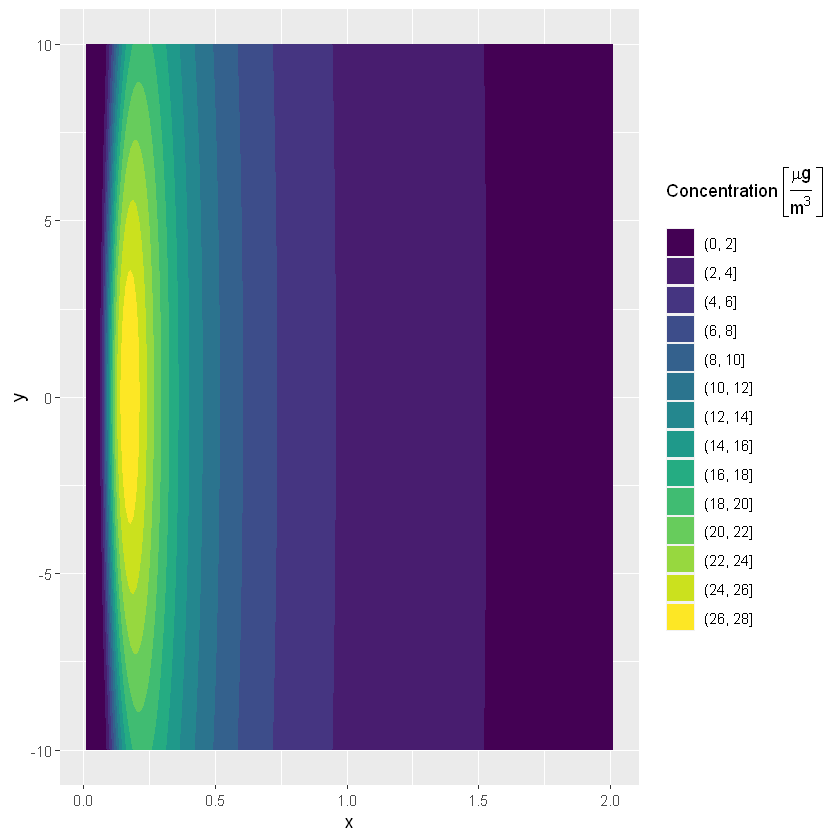

In [8]:
ggplot(surface1, aes(x,y,z=cs*10^6))+geom_contour_filled()+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))

#ggplot(surface2, aes(x,y,z=cs))+geom_contour_filled()
#ggplot(surface3, aes(x,y,z=cs))+geom_contour_filled()
#ggplot(surface4, aes(x,y,z=cs))+geom_contour_filled()
#ggplot(surface5, aes(x,y,z=cs))+geom_contour_filled()

# Nałożenie na siebie "obróconych" zbiorów punktów

## 5 godzin

In [10]:
temp1 <- transform_angle(surface1, data_wind[1,]$direction)
temp2 <- transform_angle(surface2, data_wind[2,]$direction)
temp3 <- transform_angle(surface3, data_wind[3,]$direction)
temp4 <- transform_angle(surface4, data_wind[4,]$direction)
temp5 <- transform_angle(surface5, data_wind[5,]$direction)
temp <- data.frame(x=surface1$x,y=surface1$y)
temp$cs <- temp1$cs+temp2$cs+temp3$cs+temp4$cs+temp5$cs

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.


Saving 10 x 6.67 in image


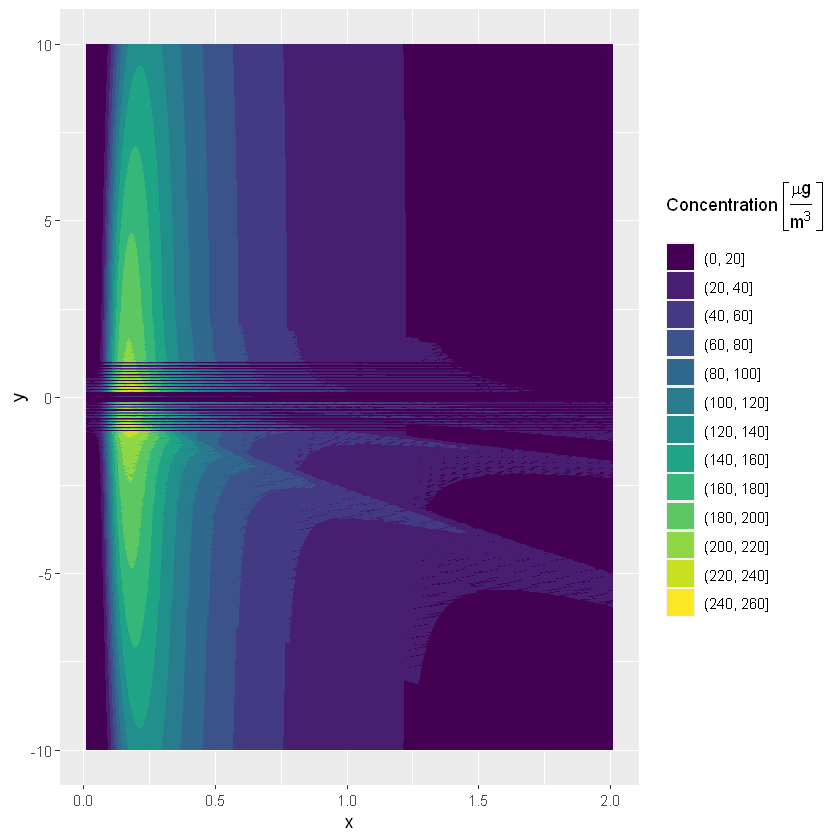

In [13]:
time_5_plot <- ggplot(temp, aes(x,y,z=cs*10^6))+geom_contour_filled()+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
time_5_plot
#ggsave('./plots/2D_time/time_5_plot.jpg', time_5_plot, 'jpg', width=10)

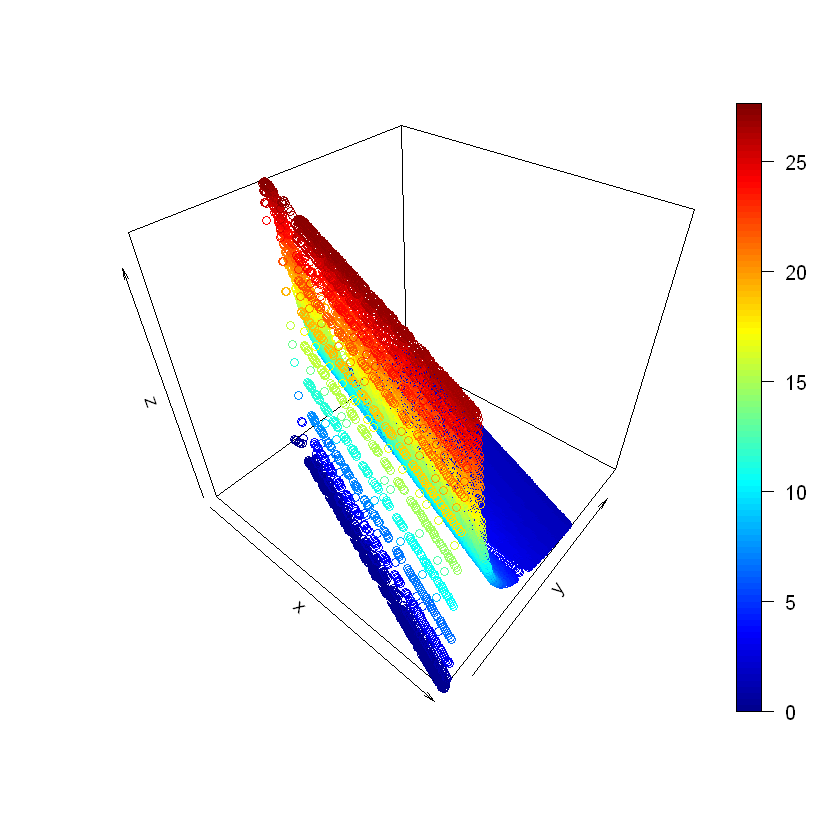

In [162]:
scatter3D(temp1$x,temp1$y,temp1$cs*10^6)

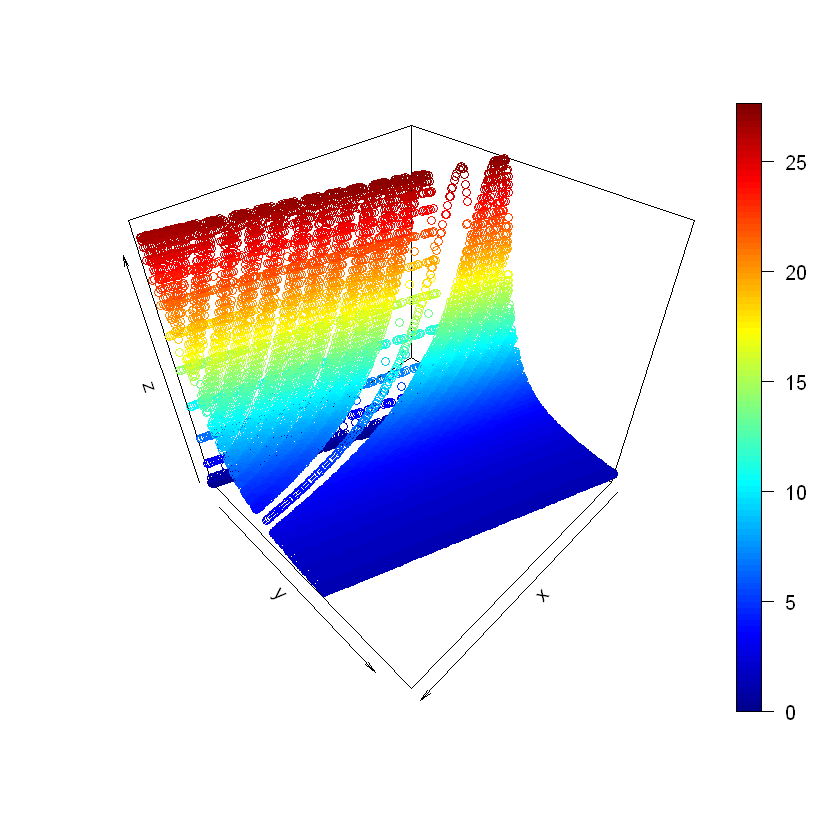

In [163]:
plotdev(theta=135)

# Wprowadzenie uśredniania siatki do modelu

In [14]:
temp <- transform_angle(surface1, data_wind[1,]$direction)
temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp2 <- transform_angle(surface2, data_wind[2,]$direction)
temp$cs <- temp$cs+temp2$cs
temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp3 <- transform_angle(surface3, data_wind[3,]$direction)
temp$cs <- temp$cs+temp3$cs
temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp4 <- transform_angle(surface4, data_wind[4,]$direction)
temp$cs <- temp$cs+temp4$cs
temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp5 <- transform_angle(surface5, data_wind[5,]$direction)
temp$cs <- temp$cs+temp5$cs

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.


Saving 10 x 6.67 in image


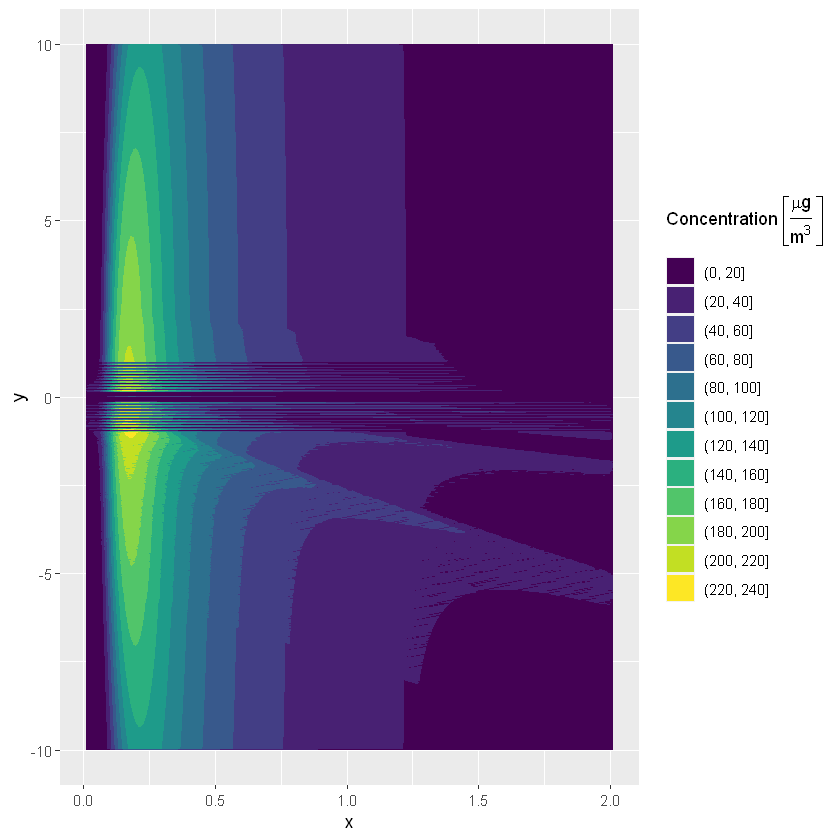

In [16]:
time_5_avg_plot <- ggplot(temp, aes(x,y,z=cs*10^6))+geom_contour_filled()+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
time_5_avg_plot
#ggsave('./plots/2D_time/time_5_avg_plot.jpg', time_5_avg_plot, 'jpg', width=10)

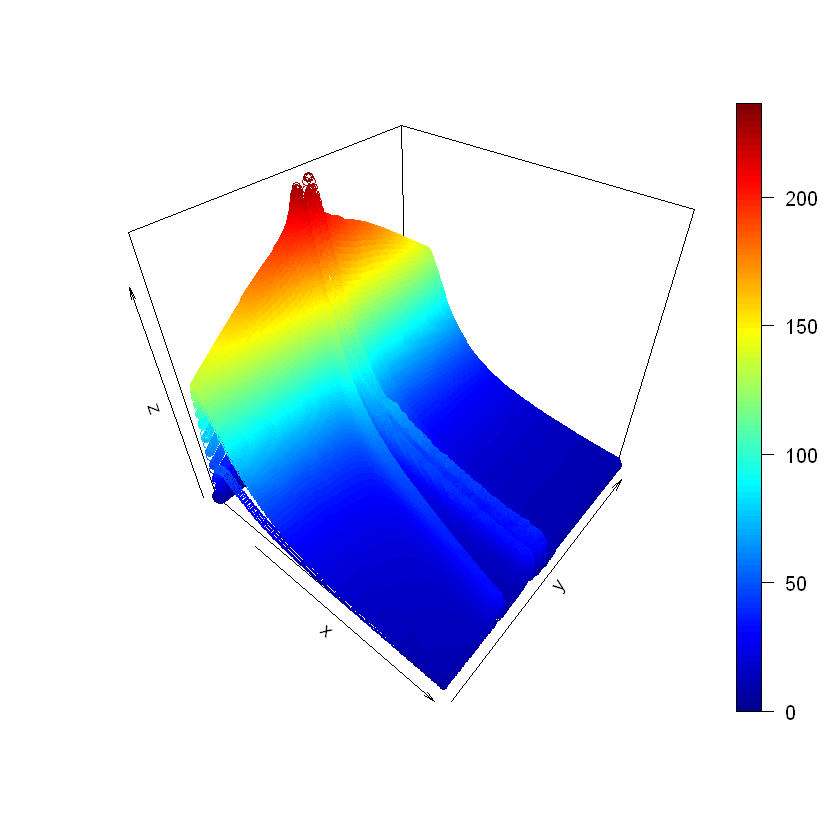

In [190]:
scatter3D(temp$x,temp$y,temp$cs*10^6)

## 10 godzin

In [ ]:
gen_in_time(6:10, sx=seq(0.01,2.01,0.01))

In [17]:
surface1 <- read.csv('./2D/surface 1 .csv')[,2:4]
surface2 <- read.csv('./2D/surface 2 .csv')[,2:4]
surface3 <- read.csv('./2D/surface 3 .csv')[,2:4]
surface4 <- read.csv('./2D/surface 4 .csv')[,2:4]
surface5 <- read.csv('./2D/surface 5 .csv')[,2:4]
surface6 <- read.csv('./2D/surface 6 .csv')[,2:4]
surface7 <- read.csv('./2D/surface 7 .csv')[,2:4]
surface8 <- read.csv('./2D/surface 8 .csv')[,2:4]
surface9 <- read.csv('./2D/surface 9 .csv')[,2:4]
surface10 <- read.csv('./2D/surface 10 .csv')[,2:4]

In [18]:
temp <- transform_angle(surface1, data_wind[1,]$direction)

temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp2 <- transform_angle(surface2, data_wind[2,]$direction)
temp$cs <- temp$cs+temp2$cs

temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp3 <- transform_angle(surface3, data_wind[3,]$direction)
temp$cs <- temp$cs+temp3$cs

temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp4 <- transform_angle(surface4, data_wind[4,]$direction)
temp$cs <- temp$cs+temp4$cs

temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp5 <- transform_angle(surface5, data_wind[5,]$direction)
temp$cs <- temp$cs+temp5$cs

temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp6 <- transform_angle(surface6, data_wind[6,]$direction)
temp$cs <- temp$cs+temp6$cs

temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp7 <- transform_angle(surface7, data_wind[7,]$direction)
temp$cs <- temp$cs+temp7$cs

temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp8 <- transform_angle(surface8, data_wind[8,]$direction)
temp$cs <- temp$cs+temp8$cs

temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp9 <- transform_angle(surface9, data_wind[9,]$direction)
temp$cs <- temp$cs+temp9$cs

temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
temp10 <- transform_angle(surface10, data_wind[10,]$direction)
temp$cs <- temp$cs+temp10$cs

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.


Saving 10 x 6.67 in image


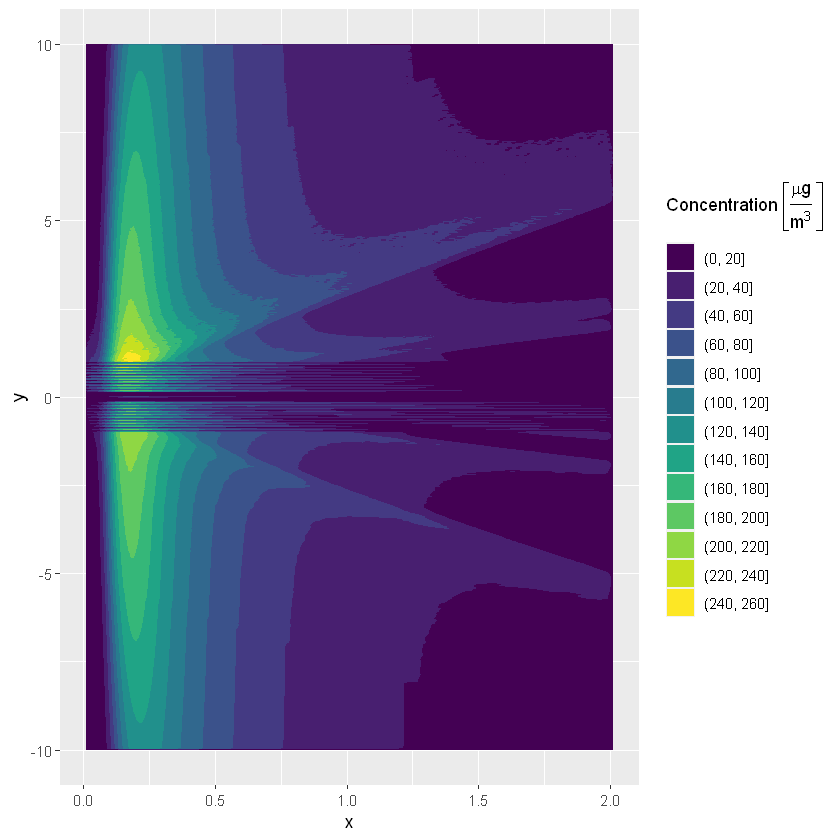

In [19]:
time_10_avg_plot <- ggplot(temp, aes(x,y,z=cs*10^6))+geom_contour_filled()+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
time_10_avg_plot
#ggsave('./plots/2D_time/time_10_avg_plot.jpg', time_10_avg_plot, 'jpg', width=10)

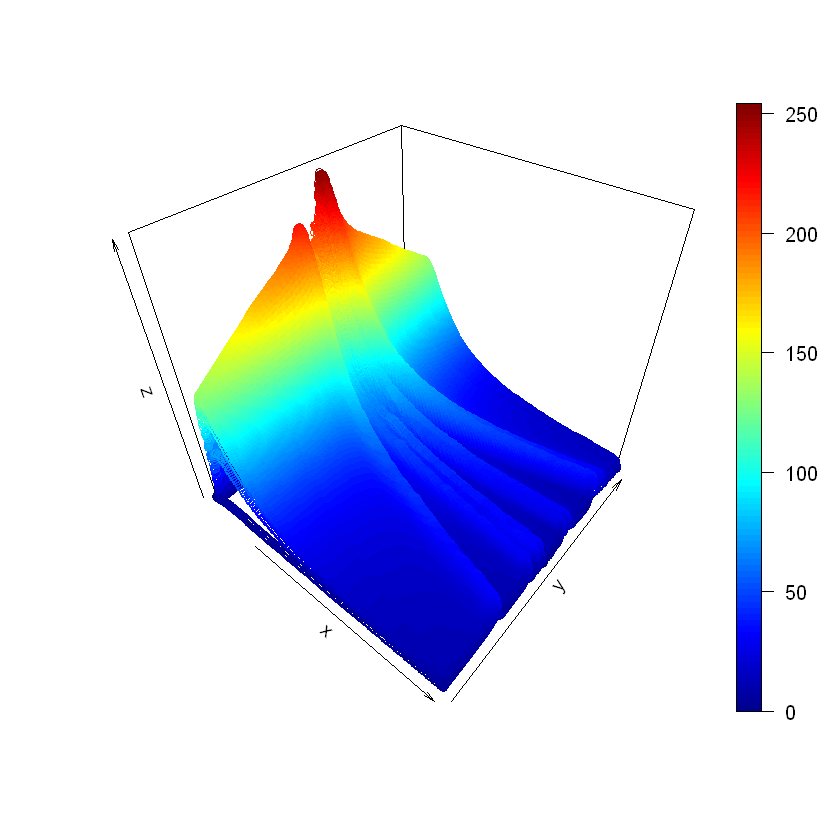

In [231]:
scatter3D(temp$x,temp$y,temp$cs*10^6)

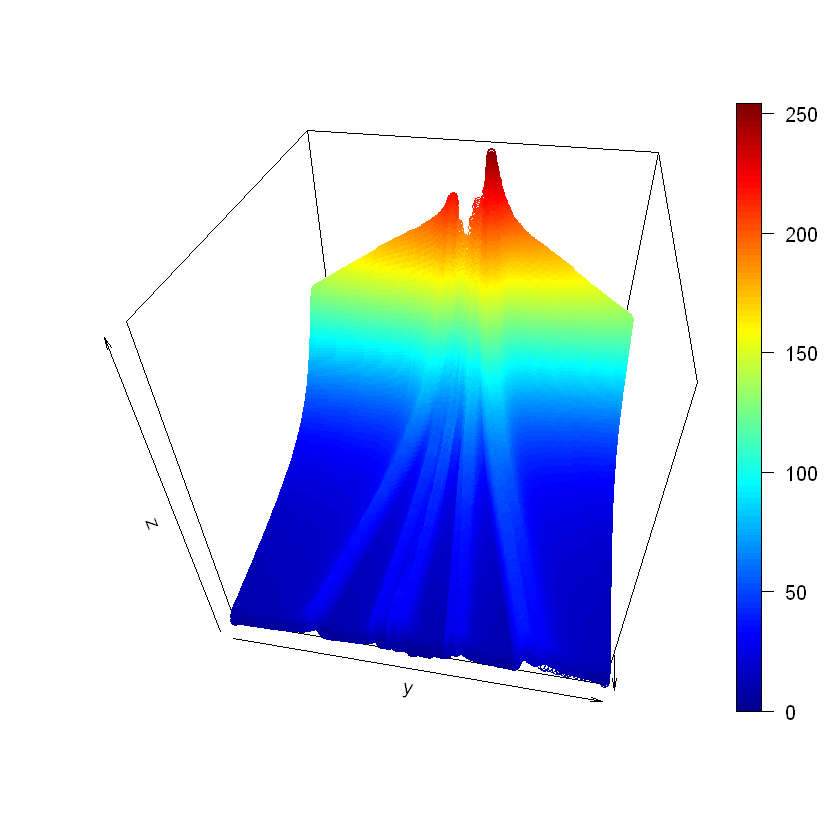

In [233]:
plotdev(theta=100)

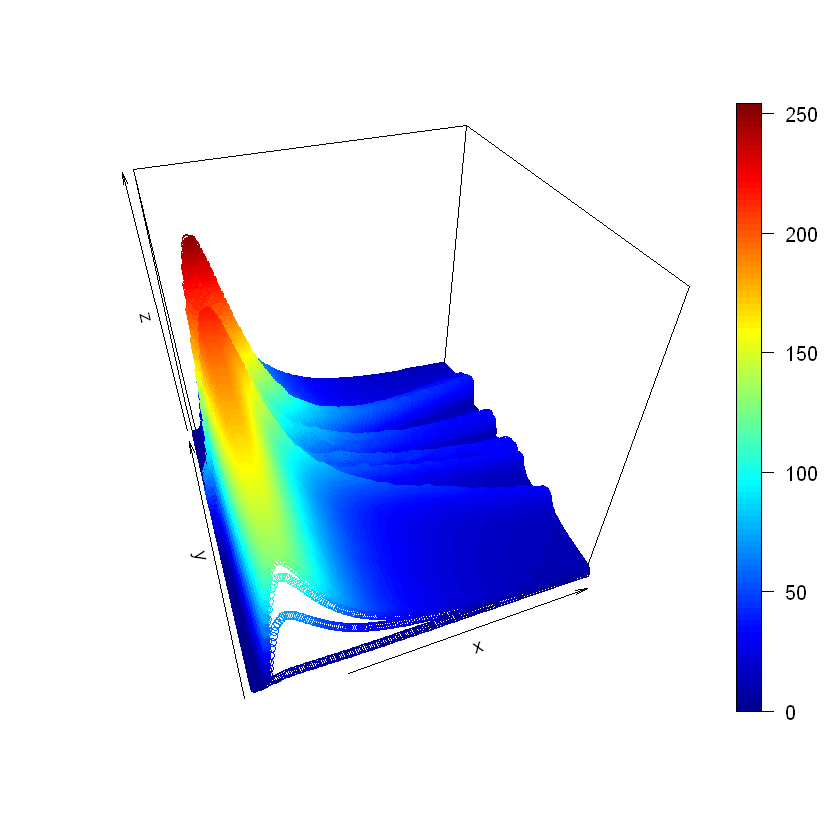

In [234]:
plotdev(theta=-20)

# Model dla dłuższego okresu (do tygodnia)

In [17]:
gen_in_time(1:168, sx=seq(0.01,2.01,0.01))

NULL

In [17]:
surface1 <- read.csv('./2D_p/surface 1 .csv')[,2:4]
temp <- transform_angle(surface1, data_wind[1,]$direction)
for(j in 1:28){
    for(i in 1:6){
        if(i==1&j==1) next
        temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
        temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
        temp1 <- read.csv(paste('./2D_p/surface',((j-1)*6+i), '.csv'))[,2:4]
        temp1 <- transform_angle(temp1, data_wind[((j-1)*6+i),]$direction)
        temp$cs <- temp$cs+temp1$cs
    }
    if(max(temp$cs*10^6)>180) breaks_seq <- c(seq(0,180,20),max(temp$cs*10^6))
    else breaks_seq <- c(seq(0,200,20))
    time_temp_plot <- ggplot(temp, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=breaks_seq)+
        scale_fill_viridis_d(drop = FALSE)+
        guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
    ggsave(paste0('./plots/2D_time/more_often/right/day',j,'_plot.jpg'), time_temp_plot, 'jpg', width=10)
}


`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summa

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the 

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image


## Próbna zmiana bazowego kierunku wiatru 
wybranie nowego kierunku wiatru na podstawie średniej wybranych danych rzeczywistych

In [23]:
direc <- c()
for(i in 1:7){
    for(j in 1:24) direc <- c(direc, data_wind[i*j,]$direction)
}

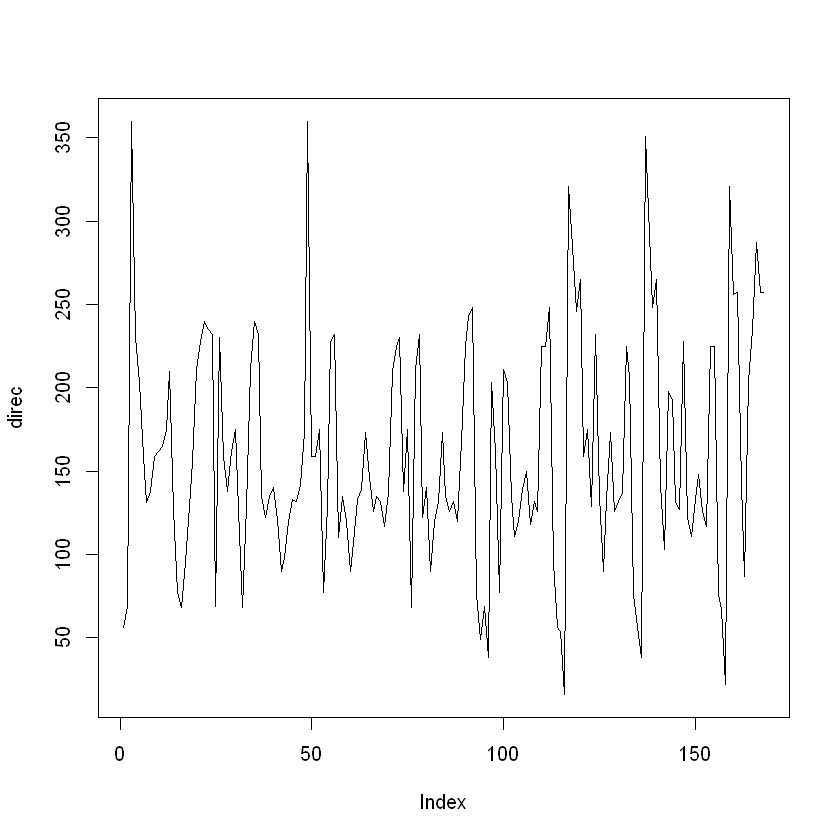

In [24]:
ggplot(mapping=aes(1:length(direc), direc))

In [18]:
transform_angle2 <- function(df,angle){
    angle <- 360-angle+180
    x1 <- round(df$x*cos(angle*2*pi/360)-df$y*sin(angle*2*pi/360),2)
    y1 <- round(df$y*cos(angle*2*pi/360)+df$x*sin(angle*2*pi/360),2)
    result <- data.frame(x=x1,y=y1,cs=df$cs)
    result <- result %>% group_by(x,y) %>% summarize(cs=mean(cs))
    final <- df[,c('y','x')] %>% left_join(result, by=c('y','x'))
    final[is.na(final$cs),'cs']=0
    return(final)
}

In [19]:
surface1 <- read.csv('./2D_p/surface 1 .csv')[,2:4]
temp <- transform_angle2(surface1, data_wind[1,]$direction)
for(j in 1:28){
    for(i in 1:6){
        if(i==1&j==1) next
        temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
        temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
        temp1 <- read.csv(paste('./2D_p/surface',((j-1)*6+i), '.csv'))[,2:4]
        temp1 <- transform_angle2(temp1, data_wind[((j-1)*6+i),]$direction)
        temp$cs <- temp$cs+temp1$cs
    }
    if(max(temp$cs*10^6)>180) breaks_seq <- c(seq(0,180,20),max(temp$cs*10^6))
    else breaks_seq <- c(seq(0,200,20))
    time_temp_plot <- ggplot(temp, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=breaks_seq)+
        scale_fill_viridis_d(drop = FALSE)+
        scale_x_reverse()+
        guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
    ggsave(paste0('./plots/2D_time/more_often/left/day',j,'_2_plot.jpg'), time_temp_plot, 'jpg', width=10)
}

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summa

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the 

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image


In [13]:
library(emojifont)

Warning message:
"pakiet 'emojifont' został zbudowany w wersji R 4.2.2"


In [6]:
emoji('cloud')

[1] "☁️"

In [93]:
time_cond_plot <- ggplot(data_wind[1:168,], aes(1:168,direction))+geom_line(col='black', linewidth=1)+
        guides(fill=guide_legend(title=TeX("Legenda")))
for(i in seq(6,168,6)){
    point <- c(i,data_wind[i,]$direction)
    time_cond_plot_temp <- time_cond_plot+geom_point(aes(x=point[1], y=(point[2])),col='hotpink')+
        geom_text(aes(x=point[1], y=(point[2])),label=emoji('cloud'), cex=30, col='hotpink', family='EmojiOne',vjust=0.06)+ylim(c(0,365))
    ggsave(paste0('./plots/2D_time/more_often/cond',i,'_plot.jpg'), time_cond_plot_temp, 'jpg', width=10)
}

Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image


In [14]:
time_cond_plot <- ggplot(data_wind[1:168,], aes(1:168,direction))+geom_line(col='black', linewidth=1)+
        guides(fill=guide_legend(title=TeX("Legenda")))
for(i in seq(6,168,6)){
    point <- c(i,data_wind[i,]$direction)
    time_cond_plot_temp <- time_cond_plot+geom_point(aes(x=point[1], y=(point[2])),col='hotpink')+
    coord_polar(theta = 'y',start=1.57, direction=1)+
    scale_y_continuous(breaks=seq(0, 360, by=30), expand=c(0,0), lim=c(0, 360))+
    geom_text(aes(x=point[1], y=point[2]),label=emoji('cloud'), cex=30, col='hotpink', family='EmojiOne',vjust=0.06)
    ggsave(paste0('./plots/2D_time/more_often/cond_polar',i,'_plot.jpg'), time_cond_plot_temp, 'jpg', width=10)
}

Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image
Saving 10 x 6.67 in image


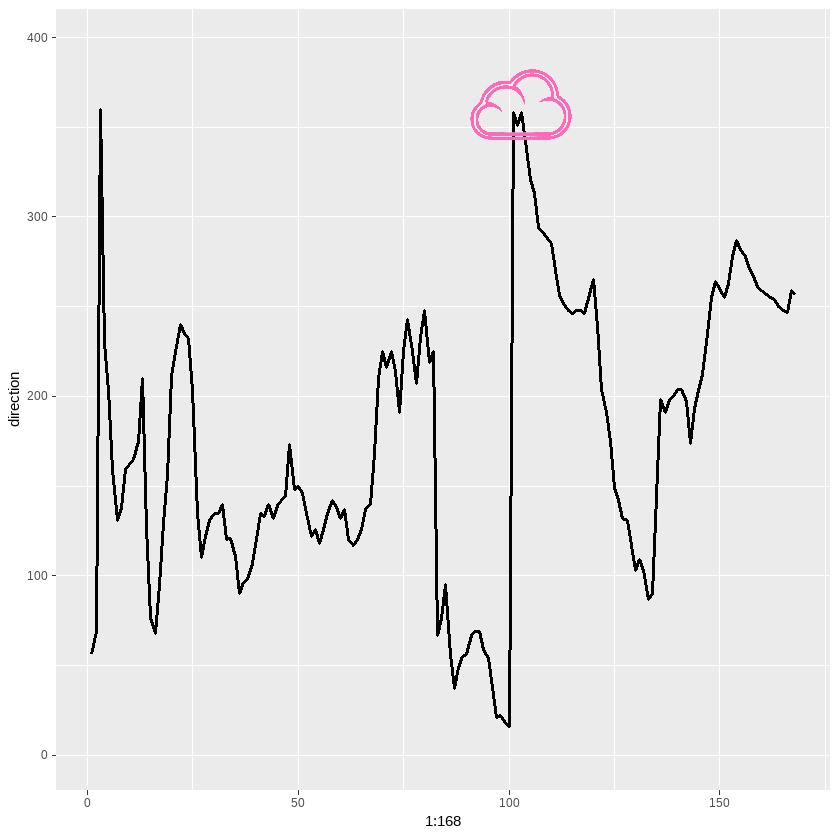

In [74]:
time_cond_plot+
        geom_text(aes(x=102, y=(data_wind[102,]$direction+45)), label=emoji('cloud'), cex=30, col='hotpink', family='EmojiOne')+ylim(c(0,396))

In [12]:
transform_angle3 <- function(df,angle){
    df1 <- data.frame(y=rep(seq(-10,10,0.01),each=403),x=rep(seq(-2.01,2.01,0.01),2001),cs=rep(0,(2001*403)))
    x1 <- round(df$x*cos(angle*2*pi/360)-df$y*sin(angle*2*pi/360),2)
    y1 <- round(df$y*cos(angle*2*pi/360)+df$x*sin(angle*2*pi/360),2)
    result <- data.frame(x=x1,y=y1,cs=df$cs)
    result <- result %>% group_by(x,y) %>% summarize(cs=mean(cs))
    final <- df1[,c('y','x')] %>% left_join(result, by=c('y','x'))
    final[is.na(final$cs),'cs']=0
    return(final)
}

In [14]:
temp <- data.frame(y=rep(seq(-10,10,0.01),each=403),x=rep(seq(-2.01,2.01,0.01),2001),cs=rep(0,(2001*403)))
for(j in 1:28){
    for(i in 1:6){
        temp_mat <- t(matrix(temp$cs, nrow=length(unique(temp$x)),ncol=length(unique(temp$y))))
        temp$cs <- c(t(pollution_average2(temp_mat,length(unique(temp$y)),length(unique(temp$x)))))
        temp1 <- read.csv(paste('./2D_p/surface',((j-1)*6+i), '.csv'))[,2:4]
        temp1 <- transform_angle3(temp1, data_wind[((j-1)*6+i),]$direction)
        temp$cs <- temp$cs+temp1$cs
    }
    if(max(temp$cs*10^6)>40) breaks_seq <- c(seq(0,40,5),max(temp$cs*10^6))
    else breaks_seq <- c(seq(0,45,5))
    time_temp_plot <- ggplot(temp, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=breaks_seq)+
        scale_fill_viridis_d(drop = FALSE)+
        guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
    ggsave(paste0('./plots/2D_time/more_often/all/day',j,'_plot.jpg'), time_temp_plot, 'jpg', width=10)
}

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summa

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the 

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
Saving 10 x 6.67 in image


In [16]:
round(rnorm(10,0,10),1)

[1] -16.5  -2.8   3.6   5.9  11.7   7.0  -5.4   5.1 -12.0   9.0